Here is simple example of using handcrafted agents in MINOS simulator

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import argparse
import gym
import gym_minos
import matplotlib.pyplot as plt
import torch
from minos.config.sim_args import parse_sim_args
import sys
import os
sys.path.insert(0, '../')
from navigation.ClassicAgents import LoggingAgent,BlindAgent, ClassicAgentWithDepth, defaultAgentOptions, ClassicAgentWithStereo
from torch import tensor


In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
sys.argv = ['-f', '--sensors', 'right',  '--env_config', 'pointgoal_mp3d_m', '--episode-schedule', 'test']
parser = argparse.ArgumentParser()
parser.add_argument('--save_observations', action='store_true',
                    default=False,
                    help='Save sensor observations at each step to images')
parser.add_argument('--num-episodes-per-scene', type=int,
                    default=1,
                    help='Number of diffent random start and end locations')
parser.add_argument('--episode-schedule', type=str,
                    default='val',
                    help='Split to use. Possible are: train, val, test. Paper reports results on test')
    
args = parse_sim_args(parser)
args['observations']['depth'] = True
args['observations']['right'] = True
args['observations']['map'] = True
args['resolution'] = 512
args['width'] = 512
args['height'] = 512


args['agent']['eyeHeight'] = 1.09
args['available_controls'] = ['turnLeft', 'turnRight', 'forwards', 'backwards', 'strafeLeft', 'strafeRight', 'lookDown', 'lookUp']


In [3]:

args['modalities'].append('right')

args['outputs'].append('right')


/home/old-ufo/storage/anaconda3/envs/NavigationBenchmarkMinosNew/lib/python3.6/site-packages/gym/envs/registration.py:17: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)
2019-02-05 17:12:29,186 INFO {'sim_id': 'sim00', 'machine': 'oldufo-ubuntupc', 'sim_git_hash': 'ce7b7c2', 'stk_git_hash': 'ce7b7c2'}
2019-02-05 17:12:29,201 INFO sim00:Starting sim server at /home/old-ufo/dev/navigation-benchmark/3rdparty/minos/minos/server/server.js with port 53263


train:110 episodes
test:50 episodes
val:20 episodes


2019-02-05 17:12:31,197 INFO sim00:connect
2019-02-05 17:12:31,296 INFO sim00:inited


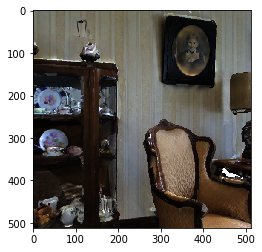

In [4]:
env = gym.make('indoor-v0')
env.configure(args)

observation = env.reset()
action = env.action_space.sample()
observation, reward, done, info = env.step(action)
plt.imshow(observation['observation']['sensors']['color']['data'])


In [5]:
args['agent_type'] = 'ClassicRGBStereo'
opts = defaultAgentOptions(args)
opts['slam_vocab_path'] = '../data/ORBvoc.txt'
opts['slam_settings_path'] = '../data/mp3d3_small1k_stereo.yaml'
Agent = ClassicAgentWithStereo(**opts)


3.1707912424647917
3.1707912424647917
3.1707912424647917
3.1707912424647917
3.1707912424647917
3.1707912424647917
3.1707912424647917
3.1707912424647917
3.1707912424647917
3.1707912424647917
tensor([[231., 209.]]) tensor([[201., 201.]], device='cuda:0')
tensor([[1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 1., 0.],
        [0., 0., 0., 1.]], device='cuda:0')


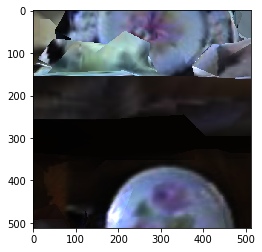

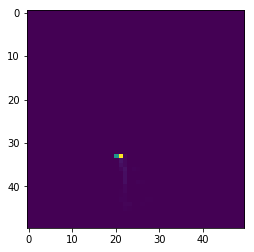

In [11]:
for i in range(10):
    dg = observation['observation']['measurements']['distance_to_goal'][0]
    action, stop = Agent.act(observation)
    observation, reward, done, info = env.step(action)
    print (dg)
plt.imshow(observation['observation']['sensors']['color']['data'])
plt.figure()
#Agent map
plt.imshow(Agent.map2DObstacles.detach().cpu().numpy().squeeze()[180:230,180:230])
print (Agent.estimatedGoalPos2D, Agent.getCurrentPositionOnMap())
print (Agent.pose6D)


In [48]:
import cv2
import numpy as np
imgL = observation['observation']['sensors']['color']['data'][:,:,:3].astype(np.uint8)
imgR = observation['observation']['sensors']['right']['data'][:,:,:3].astype(np.uint8)
#baseline=10cm
#window_size = 3
#min_disp = 0
#num_disp = 32-min_disp
#stereo = cv2.StereoSGBM_create(minDisparity = min_disp,
#    numDisparities = num_disp,
#    blockSize = 16,
#    P1 = 8*3*window_size**2,
#    P2 = 32*3*window_size**2,
#    disp12MaxDiff = 1,
#    uniquenessRatio = 10,
#    speckleWindowSize = 100,
#    speckleRange = 32
#)
# SGBM Parameters -----------------
window_size = 5                     # wsize default 3; 5; 7 for SGBM reduced size image; 15 for SGBM full size image (1300px and above); 5 Works nicely
 
left_matcher = cv2.StereoSGBM_create(
    minDisparity=0,
    numDisparities=128,             # max_disp has to be dividable by 16 f. E. HH 192, 256
    blockSize=5,
    P1=8 * 3 * window_size ** 2,    # wsize default 3; 5; 7 for SGBM reduced size image; 15 for SGBM full size image (1300px and above); 5 Works nicely
    P2=32 * 3 * window_size ** 2,
    disp12MaxDiff=1,
    uniquenessRatio=15,
    speckleWindowSize=0,
    speckleRange=2,
    preFilterCap=63,
    mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY
)

right_matcher = cv2.ximgproc.createRightMatcher(left_matcher)
# FILTER Parameters
lmbda = 80000
sigma = 1.2
visual_multiplier = 1.0
 
wls_filter = cv2.ximgproc.createDisparityWLSFilter(matcher_left=left_matcher)
wls_filter.setLambda(lmbda)
wls_filter.setSigmaColor(sigma)
displ = left_matcher.compute(imgL, imgR)  # .astype(np.float32)/16
dispr = right_matcher.compute(imgR, imgL)  # .astype(np.float32)/16
displ = np.int16(displ)
dispr = np.int16(dispr)
filteredImg = wls_filter.filter(displ, imgL, None, dispr)  # important to put "imgL" here!!!
dd = np.clip(filteredImg/16., 0, 100)
dd[dd<0] = 0
#plt.imshow(dd)
#plt.figure()
baseline = 0.2
fx = 512.
depth = baseline * fx / ((dd+1e-15))
depth = depth / 0.8
depth[depth > 3.0] = 0
depth[depth < 0.1] = 0

#filteredImg = cv2.normalize(src=filteredImg, dst=filteredImg, beta=0, alpha=255, norm_type=cv2.NORM_MINMAX);
#filteredImg = np.uint8(filteredImg)
#plt.imshow(filteredImg)


In [49]:
np.mean(depth) /  np.mean(true_depth)

0.7950078893707955

2.373117033603708 2.9298998569384835 1.8169668775008208
2.3082638 2.841383 1.7536236
max_difference 0.8093778192748005 -0.06334342479795288


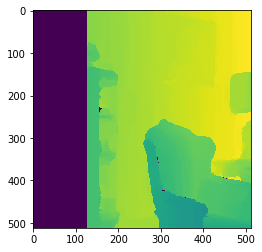

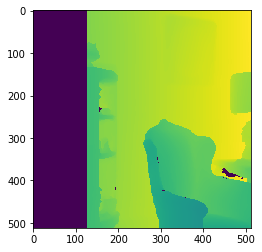

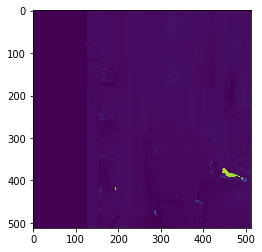

In [50]:
true_depth = observation['observation']['sensors']['depth']['data']

dd[dd<0] = 0
#plt.imshow(dd)
#plt.figure()
baseline = 0.2
fx = 512.
depth = baseline * fx / ((dd+1e-15))
depth = depth / 0.8
depth[depth > 3.0] = 0
depth[depth < 0.1] = 0
plt.figure()
plt.imshow(depth)
print (np.median(depth), np.max(depth), np.mean(depth))
plt.figure()
from copy import deepcopy
td2 = deepcopy(true_depth)
td2[td2>3] = 0
td2[depth==0] = 0
print (np.median(td2), np.max(td2), np.mean(td2))
plt.imshow(td2)
diff = td2-depth
diff[depth==0] = 0
plt.figure()
plt.imshow(np.abs(diff))
print ('max_difference', diff.max(), diff.mean())


0.0 1.9980488
max_difference 0.9102958


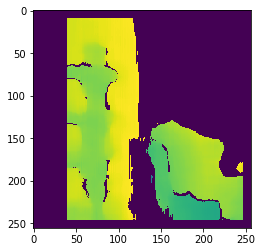

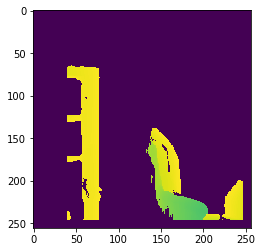

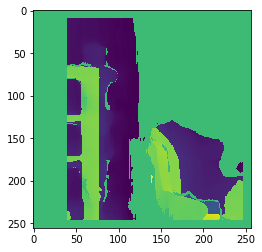

In [182]:
import cv2
import numpy as np
left = observation['observation']['sensors']['color']['data'].mean(axis=2).astype(np.uint8)
right = observation['observation']['sensors']['right']['data'].mean(axis=2).astype(np.uint8)
#baseline=10cm
#window_size = 3
#min_disp = 0
#num_disp = 32-min_disp
#stereo = cv2.StereoSGBM_create(minDisparity = min_disp,
#    numDisparities = num_disp,
#    blockSize = 16,
#    P1 = 8*3*window_size**2,
#    P2 = 32*3*window_size**2,
#    disp12MaxDiff = 1,
#    uniquenessRatio = 10,
#    speckleWindowSize = 100,
#    speckleRange = 32
#)

stereo = cv2.StereoBM().create(numDisparities=32, blockSize=19)
#disparity = stereo.create(numDisparities=16, blockSize=19)
dd = stereo.compute(left,right).astype(np.float32)/16.
dd[dd<0] = 0
#plt.imshow(dd)
#plt.figure()
baseline = 0.1
fx = 256.
depth = baseline * fx / ((dd+1e-15))
depth[depth > 2.0] = 0
depth[depth < 0.1] = 0
plt.figure()
plt.imshow(depth)
print (np.median(depth), np.max(depth))
plt.figure()
from copy import deepcopy
td2 = deepcopy(true_depth)
td2[td2>2] = 0
td2[depth==0] = 0
plt.imshow(td2)
diff = td2-depth
diff[depth==0] = 0
plt.figure()
plt.imshow(diff)
print ('max_difference', diff.max())


In [145]:
dd

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

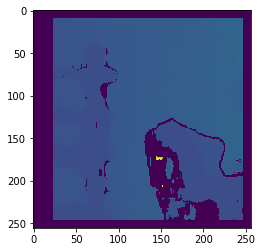

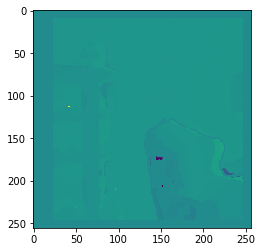

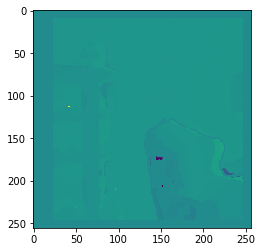

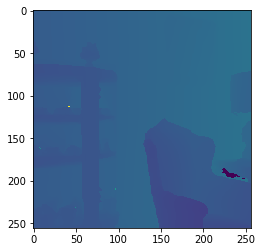

In [149]:
true_depth = observation['observation']['sensors']['depth']['data']
np.median(true_depth)
plt.imshow(true_depth)

In [67]:
h, w = left.shape[:2]
f = w                          # guess for focal length
Q = np.float32([[1, 0, 0, -0.5*w],
                [0,-1, 0,  0.5*h], # turn points 180 deg around x-axis,
                [0, 0, 0,     -f], # so that y-axis looks up
                [0, 0, 1,      0]])
points = cv2.reprojectImageTo3D(dd, Q)


In [68]:
points

array([[[ 8.    , -8.    , 16.    ],
        [ 7.9375, -8.    , 16.    ],
        [ 7.875 , -8.    , 16.    ],
        ...,
        [    inf,     inf,    -inf],
        [    inf,     inf,    -inf],
        [    inf,     inf,    -inf]],

       [[ 8.    , -7.9375, 16.    ],
        [ 7.9375, -7.9375, 16.    ],
        [ 7.875 , -7.9375, 16.    ],
        ...,
        [    inf,     inf,    -inf],
        [    inf,     inf,    -inf],
        [    inf,     inf,    -inf]],

       [[ 8.    , -7.875 , 16.    ],
        [ 7.9375, -7.875 , 16.    ],
        [ 7.875 , -7.875 , 16.    ],
        ...,
        [    inf,     inf,    -inf],
        [    inf,     inf,    -inf],
        [    inf,     inf,    -inf]],

       ...,

       [[ 8.    ,  7.8125, 16.    ],
        [ 7.9375,  7.8125, 16.    ],
        [ 7.875 ,  7.8125, 16.    ],
        ...,
        [    inf,    -inf,    -inf],
        [    inf,    -inf,    -inf],
        [    inf,    -inf,    -inf]],

       [[ 8.    ,  7.875 , 16.    ],
  

In [10]:
help(cv2.StereoBM)

Help on class StereoBM in module cv2:

class StereoBM(StereoMatcher)
 |  Method resolution order:
 |      StereoBM
 |      StereoMatcher
 |      Algorithm
 |      builtins.object
 |  
 |  Methods defined here:
 |  
 |  __new__(*args, **kwargs) from builtins.type
 |      Create and return a new object.  See help(type) for accurate signature.
 |  
 |  __repr__(self, /)
 |      Return repr(self).
 |  
 |  create(...) from builtins.type
 |      create([, numDisparities[, blockSize]]) -> retval
 |      .   @brief Creates StereoBM object
 |      .   
 |      .   @param numDisparities the disparity search range. For each pixel algorithm will find the best
 |      .   disparity from 0 (default minimum disparity) to numDisparities. The search range can then be
 |      .   shifted by changing the minimum disparity.
 |      .   @param blockSize the linear size of the blocks compared by the algorithm. The size should be odd
 |      .   (as the block is centered at the current pixel). Larger block 

Now agents

In [7]:
args['agent_type'] = 'ClassicRGBStereo'
opts = defaultAgentOptions(args)
opts['slam_vocab_path'] = '../data/ORBvoc.txt'
opts['slam_settings_path'] = '../data/mp3d3_small1k_stereo.yaml'
Agent = ClassicAgentWithStereo(**opts)
for i in range(10):
    dg = observation['observation']['measurements']['distance_to_goal'][0]
    action, stop = Agent.act(observation)
    observation, reward, done, info = env.step(action)
    print (dg)
plt.imshow(observation['observation']['sensors']['color']['data'])
plt.figure()


NameError: name 'left_matcher' is not defined

2.8703318677220127
2.869717887270541
2.8694367539861836
2.8693026538470936
2.869237220670956
2.869204908338705
2.869188853240529
2.8691808509589234
2.8691768561350544
2.8691748603023592


<Figure size 432x288 with 0 Axes>

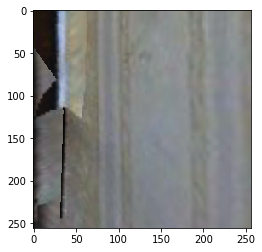

<Figure size 432x288 with 0 Axes>

In [24]:
for i in range(10):
    dg = observation['observation']['measurements']['distance_to_goal'][0]
    action, stop = Agent.act(observation)
    observation, reward, done, info = env.step(action)
    print (dg)
plt.imshow(observation['observation']['sensors']['color']['data'])
plt.figure()


tensor([[245., 183.]]) tensor([[207., 198.]], device='cuda:0')
tensor([[[ 9.0632e-01, -6.6127e-04, -4.2259e-01, -2.8647e-01],
         [-1.2690e-03,  9.9999e-01, -4.2864e-03,  6.8456e-03],
         [ 4.2259e-01,  4.4212e-03,  9.0631e-01,  6.0457e-01],
         [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  1.0000e+00]]],
       device='cuda:0')


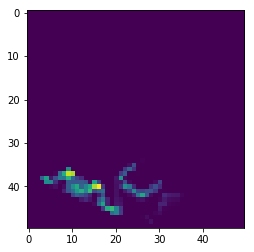

In [7]:
#Agent map
plt.imshow(Agent.map2DObstacles.detach().cpu().numpy().squeeze()[180:230,180:230])
print (Agent.estimatedGoalPos2D, Agent.getCurrentPositionOnMap())
print (Agent.pose6D)
